<div style="background-color:#3c3d41;padding:30px;border-radius:5px">

<h1 style="font-size:22px;color:white;margin-top:0px">
2023 Nova Scotia (Canada) WildFire Case Study: <br>
Plotting NOAA VIIRS Fire Mask
</h1>

<p style="font-size:14px;color:white">
Author: Benjamin Marchant<br>
License: CC BY 4.0
</p>
  
</div>

In [11]:
from scipy.spatial.distance import cdist
from scipy.interpolate import griddata
from scipy.interpolate.interpnd import _ndim_coords_from_arrays
from scipy.spatial import cKDTree
from matplotlib.pyplot import figure
from pylab import matplotlib

import netCDF4
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import warnings
import matplotlib.patches as mpatches
import seaborn as sns; sns.set()

In [12]:
root = '/Volumes/HD15TB/Datasets/Research/NOAA_AWS/'

In [13]:
instrument = "VIIRS"

platform = "NOAA20"
platform = "SNPP"
platform = "NOAA21"

product = "AF_Iband_VIIRS_EDR" 

In [14]:
year = 2023
month = 8
day = 9


year = 2023
month = 5
day = 30

current_date = "{:04d}_{:02d}_{:02d}".format(year,month,day)

In [15]:
media_path = '{}/{}/{}/{}/{}/{}'.format(root,platform,instrument,product,year,current_date)

In [16]:
GITCO_FileName = 'GITCO_j01_d20230808_t1557229_e1603029_b29642_c20230808163000588000_oeac_ops.h5'
GITCO_FileName = 'GITCO_j01_d20230809_t1534123_e1539523_b29656_c20230809160821278000_oeac_ops.h5'

GITCO_FileName = 'GITCO_j01_d20230531_t1655313_e1701113_b28664_c20230531172202549950_oeac_ops.h5'
GITCO_FileName = 'GITCO_j01_d20230530_t1718419_e1724219_b28650_c20230530173514676978_oeac_ops.h5'

GITCO_FileName = 'GITCO_npp_d20230530_t1628549_e1630191_b60046_c20230530164722627050_oeac_ops.h5'

GITCO_FileName = 'GITCO_j02_d20230530_t1741271_e1742518_b02858_c20230530175836490316_oeac_ops.h5'

delta_minutes = 0

In [17]:
m = round(delta_minutes / 1.4166666833333332)

df_GMTCO = pd.DataFrame()

f = netCDF4.Dataset( GITCO_FileName )

gr_all_data = f.groups['All_Data']

gr_VIIRS_IMG_GEO_TC_All = gr_all_data.groups['VIIRS-IMG-GEO-TC_All']

for variable in ['Latitude','Longitude']:
    sds_obj = gr_VIIRS_IMG_GEO_TC_All.variables[variable]
    data =  ma.getdata(sds_obj)

    #idx_start = int( (data.shape[0]/4) * m )
    #idx_end = int( (data.shape[0]/4) * m + (data.shape[0]/4) ) 

    #data = data[idx_start:idx_end,:]
    
    df_GMTCO[variable] = data.ravel()

x_axis_size = data.shape[1]
y_axis_size = data.shape[0] 

xv, yv = np.meshgrid(np.arange(0,x_axis_size), np.arange(0,y_axis_size))

df_GMTCO['sample'] = xv.flatten() 
df_GMTCO['line'] = yv.flatten() 

f.close()

print( df_GMTCO )

          Latitude  Longitude  sample  line
0        42.207699 -53.919346       0     0
1        42.207817 -53.929024       1     0
2        42.207932 -53.938690       2     0
3        42.208050 -53.948349       3     0
4        42.208164 -53.957989       4     0
...            ...        ...     ...   ...
9830395  41.618561 -91.547256    6395  1535
9830396  41.615753 -91.555435    6396  1535
9830397  41.612762 -91.564163    6397  1535
9830398  41.609699 -91.573082    6398  1535
9830399  41.606693 -91.581841    6399  1535

[9830400 rows x 4 columns]


<AxesSubplot:>

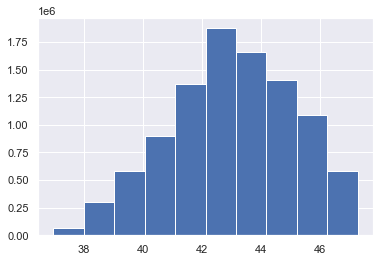

In [18]:
df_GMTCO['Latitude'].hist()

In [19]:
AF_FileName = 'AF-Iband_v1r1_j01_s202308081555589_e202308081557216_c202308081634437.nc'
AF_FileName = 'AF-Iband_v1r1_j01_s202308091537020_e202308091538265_c202308091614278.nc'

AF_FileName = 'AF-Iband_v1r1_j01_s202305311658210_e202305311659456_c202305311724431.nc'
AF_FileName = 'AF-Iband_v1r1_j01_s202305301718419_e202305301720064_c202305301740165.nc'

AF_FileName = 'AF-Iband_v1r1_npp_s202305301628549_e202305301630191_c202305301658291.nc'

AF_FileName = 'AF-Iband_v1r1_n21_s202305301741271_e202305301742518_c202305301808251.nc'

In [20]:
df_VIIRS_FireMask = pd.DataFrame()
df_VIIRS_FirePixels = pd.DataFrame()

f = netCDF4.Dataset( '{}/{}'.format(media_path, AF_FileName) )

#print(f)

fmg = f.groups['Fire Mask']

fire_mask_v = fmg.variables['fire_mask']

data =  ma.getdata(fire_mask_v)

df_VIIRS_FireMask['fire_mask'] = data.ravel()

x_axis_size = data.shape[1]
y_axis_size = data.shape[0] 

xv, yv = np.meshgrid(np.arange(0,x_axis_size), np.arange(0,y_axis_size))

df_VIIRS_FireMask['sample'] = xv.flatten() 
df_VIIRS_FireMask['line'] = yv.flatten() 

fpg = f.groups['Fire Pixels']

for key in fpg.variables.keys():

    data_obj = fpg.variables[key]

    data =  ma.getdata(data_obj)

    df_VIIRS_FirePixels[key] = data.ravel()

df_VIIRS_FirePixels.rename(columns={'FP_sample': 'sample'}, inplace=True)
df_VIIRS_FirePixels.rename(columns={'FP_line': 'line'}, inplace=True)

df_VIIRS_FirePixels['sample'] = df_VIIRS_FirePixels['sample'].astype('int64')
df_VIIRS_FirePixels['line'] = df_VIIRS_FirePixels['line'].astype('int64')

f.close()

print(df_VIIRS_FireMask)
print(df_VIIRS_FirePixels)

         fire_mask  sample  line
0                1       0     0
1                1       1     0
2                1       2     0
3                1       3     0
4                1       4     0
...            ...     ...   ...
9830395          1    6395  1535
9830396          1    6396  1535
9830397          1    6397  1535
9830398          1    6398  1535
9830399          1    6399  1535

[9830400 rows x 3 columns]
     line  sample  FP_latitude  FP_longitude       FP_T4       FP_T5  \
0      93    4918    39.574089    -80.821938  330.847870  295.082489   
1      95    3748    40.859020    -74.616188  328.227264  301.568970   
2      99    4472    40.092663    -78.519058  326.451080  299.045288   
3     102    4916    39.574528    -80.818901  330.534851  294.559479   
4     119    4791    39.818050    -80.134026  341.553497  303.502991   
..    ...     ...          ...           ...         ...         ...   
188  1220    5190    42.643051    -84.229355  341.174957  306.746216   


In [21]:
df_VIIRS_FireMask['fire_mask'].value_counts()

5    4881627
3    3230696
1    1265664
4     440988
2      11224
8        142
9         34
7         17
6          8
Name: fire_mask, dtype: int64

In [22]:
df_merged = pd.merge(df_GMTCO,df_VIIRS_FireMask, on=['sample','line'], how='inner')

df_merged = pd.merge(df_merged,df_VIIRS_FirePixels, on=['sample','line'], how='outer')

df_merged

,Latitude,Longitude,sample,line,fire_mask,FP_latitude,FP_longitude,FP_T4,FP_T5,FP_MeanT4,...,FP_AdjCloud,FP_AdjWater,FP_WinSize,FP_confidence,FP_day,FP_SolZenAng,FP_SolAzAng,FP_ViewZenAng,FP_ViewAzAng,FP_PersistentAnomalyCategory
0,42.207699,-53.919346,0,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,42.207817,-53.929024,1,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,42.207932,-53.938690,2,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,42.208050,-53.948349,3,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,42.208164,-53.957989,4,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9830395,41.618561,-91.547256,6395,1535,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9830396,41.615753,-91.555435,6396,1535,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9830397,41.612762,-91.564163,6397,1535,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9830398,41.609699,-91.573082,6398,1535,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
print( df_merged["Latitude"].min() )
print( df_merged["Latitude"].max() )

36.95905303955078
47.29010772705078


In [24]:
print( df_merged["Longitude"].min() )
print( df_merged["Longitude"].max() )

-91.58184051513672
-53.91739273071289


In [25]:
target_lat = 20.7984
target_lon = 156.3319

In [26]:
target_lat = 43.7633
target_lon = 65.3235

In [27]:
df_merged = df_merged[ df_merged["Latitude"] > -999.0 ]

In [28]:
print( df_merged["Latitude"].min() )
print( df_merged["Latitude"].max() )

36.95905303955078
47.29010772705078


In [29]:
df_merged["fire_mask"].value_counts()

5    4881627
3    3230696
1    1265664
4     440988
2      11224
8        142
9         34
7         17
6          8
Name: fire_mask, dtype: int64

In [30]:
target_lat = 43.7580
target_lon = -65.3208

In [31]:
granule_min_long = target_lon- 1.1
granule_max_long = target_lon+ 1.1

granule_min_lat = target_lat- 1.1
granule_max_lat = target_lat+ 1.1

#---------------------------------------------------------------------#

#print( df_merged['fire_mask'].value_counts() )

df_merged_without_bowtie = df_merged[ df_merged['fire_mask'] > 1 ]

df_merged_without_bowtie[['Longitude','Latitude']].to_numpy()

xy1_igrid = df_merged_without_bowtie[['Longitude','Latitude']].to_numpy() 

z_igrid_01 = df_merged_without_bowtie[['fire_mask']].to_numpy()
z_igrid_01 = z_igrid_01.astype('float64')

#---------------------------------------------------------------------#

xi, yi = np.mgrid[granule_min_long:granule_max_long:1000j, granule_min_lat:granule_max_lat:1000j]

z_01 = griddata(xy1_igrid, z_igrid_01, (xi, yi), method='nearest')

#----------#

THRESHOLD = 0.05

tree = cKDTree(xy1_igrid)
arr_x = _ndim_coords_from_arrays((xi, yi))
dists, indexes = tree.query(arr_x)

z_01[dists > THRESHOLD] = np.nan

#----------#

whereAreNaNs = np.isnan(z_01);
z_01[whereAreNaNs] = 0.;

In [32]:
z_01

array([[[3.],
        [3.],
        [3.],
        ...,
        [3.],
        [3.],
        [3.]],

       [[3.],
        [3.],
        [3.],
        ...,
        [3.],
        [3.],
        [3.]],

       [[3.],
        [3.],
        [3.],
        ...,
        [3.],
        [3.],
        [3.]],

       ...,

       [[3.],
        [3.],
        [3.],
        ...,
        [5.],
        [5.],
        [5.]],

       [[3.],
        [3.],
        [3.],
        ...,
        [5.],
        [5.],
        [5.]],

       [[3.],
        [3.],
        [3.],
        ...,
        [5.],
        [5.],
        [5.]]])

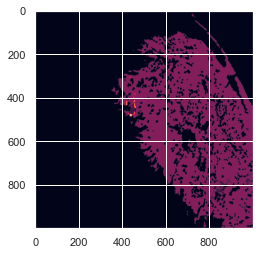

In [33]:
plt.imshow(z_01)

plt.show()

In [34]:
z_01.shape

(1000, 1000, 1)

In [35]:
min_long = granule_min_long
max_long = granule_max_long

min_lat = granule_min_lat
max_lat = granule_max_lat

In [54]:
import cartopy.io.img_tiles as cimgt


cimgt.QuadtreeTiles.get_image = image_spoof # reformat web request for street map spoofing
img = cimgt.QuadtreeTiles() # spoofed, downloaded street map


plt.figure(figsize=(12,12),dpi=200, facecolor='w')

proj = ccrs.PlateCarree()

offset = 0.0

ease_extent = [min_long-offset, 
               max_long+offset, 
               min_lat-offset, 
               max_lat+offset]

ease_extent = [min_long-offset, 
               max_long+offset, 
               43.4, 
               max_lat+offset]

print(ease_extent)

ax = plt.axes(projection=proj)



ax.add_image(img, 8)



ax.set_extent(ease_extent, crs=proj) 


swe_extent = [min_long, max_long, min_lat, max_lat]


cmap = cm.get_cmap('RdBu_r', 11)    # PiYG

color_list = ['#808080']

for i in range(cmap.N):
    rgba = cmap(i)
    color_list.append(matplotlib.colors.rgb2hex(rgba))


cmap = color_list
cmap = mpl.colors.ListedColormap(cmap)


bounds = [i for i in range(11)]

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


im = ax.imshow(np.rot90(np.fliplr(z_01)), extent=swe_extent, transform=proj, origin='lower', aspect=1., cmap=cmap, norm=norm, zorder=10, alpha=0.5)

cbar_bounds = bounds
cbar_ticks =  [(cbar_bounds[i+1]-cbar_bounds[i])/2.0+cbar_bounds[i] for i in range( len(cbar_bounds) - 1 )] #  [0.5, 1.5, 155.0, 254.0, 255.0]  
#cbar_labels = [i for i in range(10)]
cbar_labels = ['Missing input data',
               'On-board bowtie deletion',
               'Sun glint',
               'Pixel classified as non-fire water',
               'Pixel classified as cloudy',
               '5 Pixel classified as non-fire land',
               'Pixel with no valid background pixels',
               'Fire pixel with confidence strictly less than 20% fire',
               'Fire pixel with confidence between 20% and 80%',
               'Fire pixel with confidence greater than or equal to 80%']

#cbar = plt.colorbar(im, cmap=cmap, norm=norm, boundaries=cbar_bounds, ticks=cbar_ticks,fraction=0.020)
#cbar.ax.set_yticklabels(cbar_labels, fontsize=10)

g1 = ax.gridlines(draw_labels=True, color='gray', linestyle='--')

ax.coastlines()

#plt.title('FIREX-AQ MASTER \n Fire Radiative Power (MW) \n {}-{}-{} {}:{} \n FRP TOT {:.2f}MW'.format(year,month,day,hour,minute,FRP_tot),fontsize=14)

g1.top_labels = False
g1.right_labels = False

plt.grid(False)

plt.tight_layout()

plt.title('J02 VIIRS (provisional) Nova Scotia (Canada) Fires 2023-05-30',fontsize=14)

plt.savefig('NOVASCOTIA_J02_2023_05_30', dpi=1000, bbox_inches='tight')

plt.show()

plt.close()

NameError: name 'image_spoof' is not defined

[-65.3, -65.7, 43.4, 43.8]


/var/folders/76/wt7m6f5d0c5523wpf5wqnpxm0000gn/T/ipykernel_62968/3588302369.py:72: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


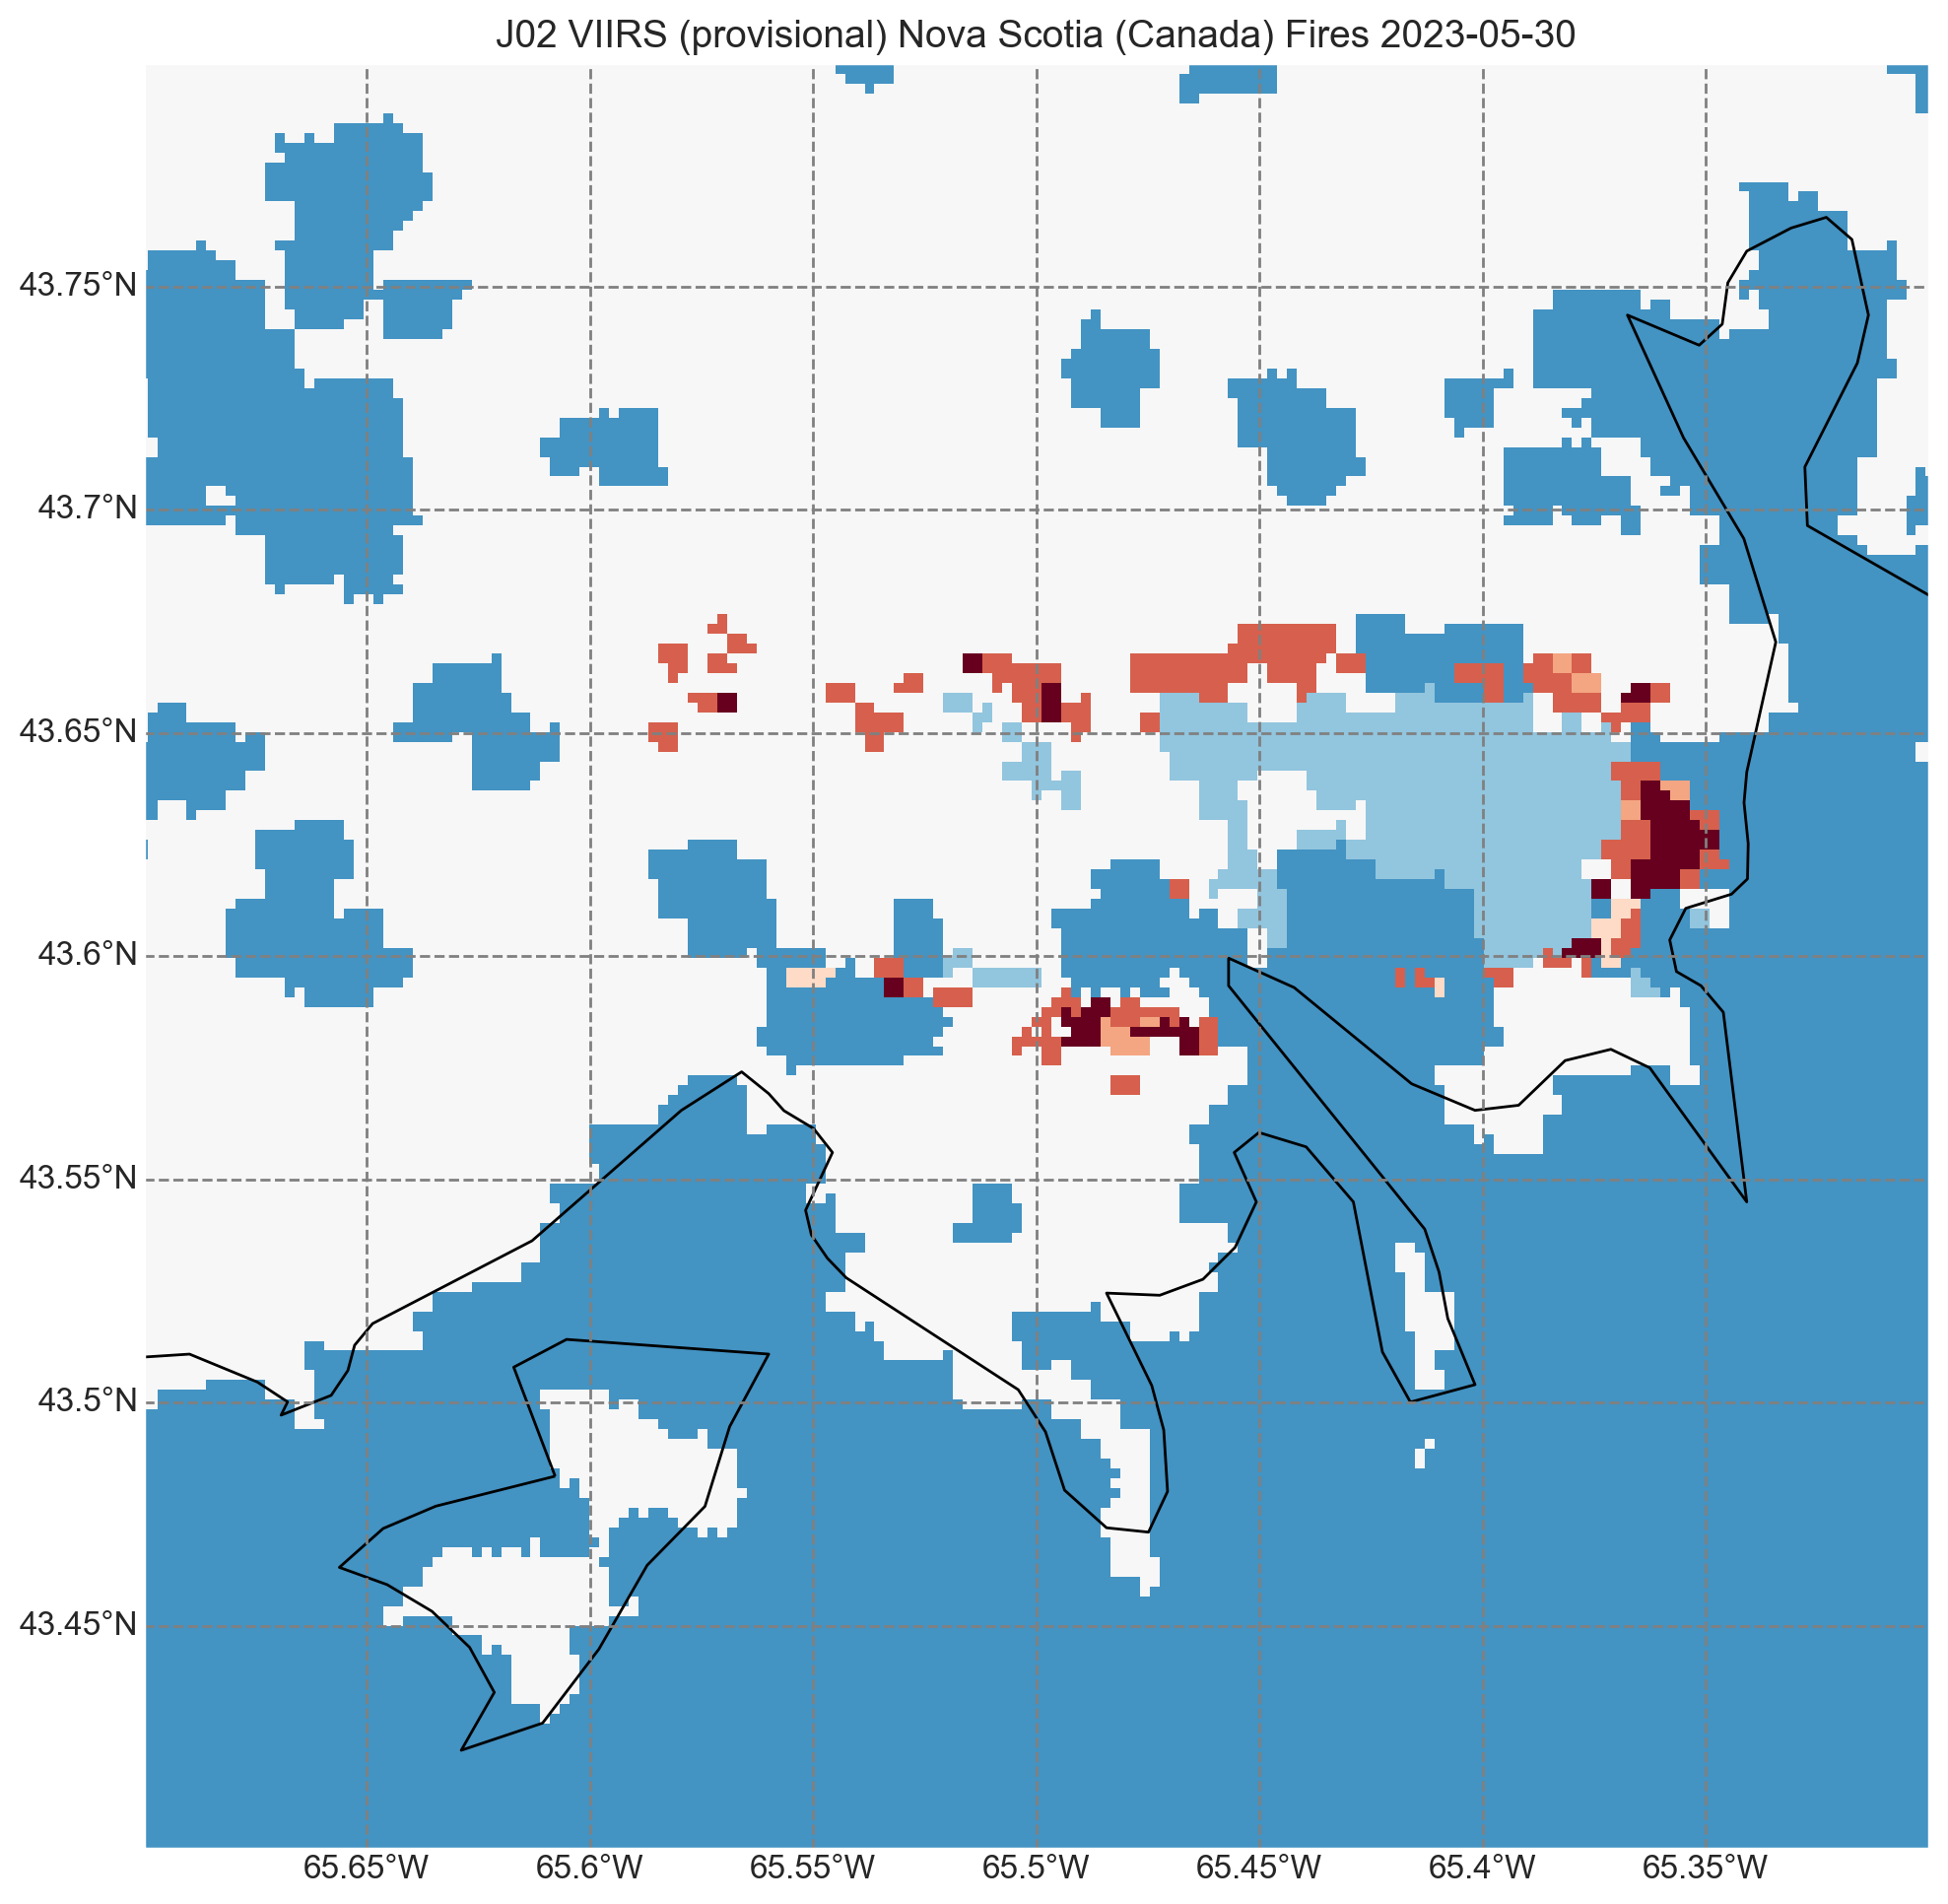

In [37]:
plt.figure(figsize=(12,12),dpi=200, facecolor='w')

proj = ccrs.PlateCarree()

offset = 0.0



ease_extent = [-65.3, 
               -65.7, 
               43.4, 
               43.8]

print(ease_extent)

ax = plt.axes(projection=proj)

ax.set_extent(ease_extent, crs=proj) 


swe_extent = [min_long, max_long, min_lat, max_lat]


cmap = cm.get_cmap('RdBu_r', 11)    # PiYG

color_list = ['#808080']

for i in range(cmap.N):
    rgba = cmap(i)
    color_list.append(matplotlib.colors.rgb2hex(rgba))


cmap = color_list
cmap = mpl.colors.ListedColormap(cmap)


bounds = [i for i in range(11)]

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


im = ax.imshow(np.rot90(np.fliplr(z_01)), extent=swe_extent, transform=proj, origin='lower', aspect=1., cmap=cmap, norm=norm)

cbar_bounds = bounds
cbar_ticks =  [(cbar_bounds[i+1]-cbar_bounds[i])/2.0+cbar_bounds[i] for i in range( len(cbar_bounds) - 1 )] #  [0.5, 1.5, 155.0, 254.0, 255.0]  
#cbar_labels = [i for i in range(10)]
cbar_labels = ['Missing input data',
               'On-board bowtie deletion',
               'Sun glint',
               'Pixel classified as non-fire water',
               'Pixel classified as cloudy',
               '5 Pixel classified as non-fire land',
               'Pixel with no valid background pixels',
               'Fire pixel with confidence strictly less than 20% fire',
               'Fire pixel with confidence between 20% and 80%',
               'Fire pixel with confidence greater than or equal to 80%']

#cbar = plt.colorbar(im, cmap=cmap, norm=norm, boundaries=cbar_bounds, ticks=cbar_ticks,fraction=0.020)
#cbar.ax.set_yticklabels(cbar_labels, fontsize=10)

g1 = ax.gridlines(draw_labels=True, color='gray', linestyle='--')

ax.coastlines()

#plt.title('FIREX-AQ MASTER \n Fire Radiative Power (MW) \n {}-{}-{} {}:{} \n FRP TOT {:.2f}MW'.format(year,month,day,hour,minute,FRP_tot),fontsize=14)

g1.top_labels = False
g1.right_labels = False

plt.grid(False)

plt.tight_layout()

plt.title('J02 VIIRS (provisional) Nova Scotia (Canada) Fires 2023-05-30',fontsize=14)

plt.savefig('NOVASCOTIA_Zoomed_J02_2023_05_30', dpi=1000, bbox_inches='tight')

plt.show()

plt.close()

In [38]:
data_jp01 = np.copy(z_01)

In [39]:
data_jp01

array([[[3.],
        [3.],
        [3.],
        ...,
        [3.],
        [3.],
        [3.]],

       [[3.],
        [3.],
        [3.],
        ...,
        [3.],
        [3.],
        [3.]],

       [[3.],
        [3.],
        [3.],
        ...,
        [3.],
        [3.],
        [3.]],

       ...,

       [[3.],
        [3.],
        [3.],
        ...,
        [5.],
        [5.],
        [5.]],

       [[3.],
        [3.],
        [3.],
        ...,
        [5.],
        [5.],
        [5.]],

       [[3.],
        [3.],
        [3.],
        ...,
        [5.],
        [5.],
        [5.]]])

In [40]:
data_snpp = np.copy(z_01)